In [277]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime

# import pmdarima as pm
# import statsmodels.tsa.api as tsa

In [278]:
print(os.getcwd())
today = datetime.today().strftime("%Y%m%d")

hist_fname = f"Realisierter_Stromverbrauch_201501010000_202310312359_Viertelstunde.csv"
recent_fname = f"Realisierter_Stromverbrauch_202311010000_{today}2359_Viertelstunde.csv"

# Load data
hist_df = pd.read_csv(f"./data/{hist_fname}", sep=";", decimal=",")
recent_df = pd.read_csv(f"./data/{recent_fname}", sep=";", decimal=",")

# merge 2 df
df = pd.concat([hist_df, recent_df])

c:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\VL - PTSFC\2023_11-PTSFC


In [279]:
# Rename columns for convenience
df.columns = ["datum", "anfang", "ende", "gesamt", "residual", "pump"]

# replace '-' with NA
df.replace('-', pd.NA, inplace=True)

# drop rows where all values in ['gesamt', 'residual', 'pump'] are NA
# df.dropna(how = 'all', inplace=True, subset=['gesamt', 'residual', 'pump'])

# DONT DROP since we are going to interpolate later

df.tail()

,datum,anfang,ende,gesamt,residual,pump
4699,19.12.2023,22:45,23:00,<NA>,<NA>,<NA>
4700,19.12.2023,23:00,23:15,<NA>,<NA>,<NA>
4701,19.12.2023,23:15,23:30,<NA>,<NA>,<NA>
4702,19.12.2023,23:30,23:45,<NA>,<NA>,<NA>
4703,19.12.2023,23:45,00:00,<NA>,<NA>,<NA>


In [280]:
# Merge date and time column and set that as the index
df["timestamp"] = pd.to_datetime(df['datum'] + ' ' + df['anfang'], format='%d.%m.%Y %H:%M')

# need to choose anfang here !!!
# otherwise in DST switching end of march we will have 3am twice

# 1:30 - 2:00
# 2:00 - 2:30
# 2:30 - 3:00
# 2:00 - 2:30
# 2:30 - 3:00
# 3:00 - 3:30

# taking anfang ...

# 1:30
# 2:00
# 2:30
# 2:00
# 2:30
# 3:00

# taking ende ...

# 2:00
# 2:30
# 3:00
# 2:30
# 3:00
# 3:30

# is NOT fine (see example)

# s = pd.Series(range(7), index=pd.DatetimeIndex(['2015-10-25 01:30:00',
#                                                 '2015-10-25 02:00:00',
#                                                 '2015-10-25 02:30:00', 
#                                                 # '2015-10-25 03:00:00',
#                                                 '2015-10-25 02:00:00',
#                                                 '2015-10-25 02:30:00',
#                                                 '2015-10-25 03:00:00',
#                                                 '2015-10-25 03:30:00']))
                                                
# s.tz_localize('CET', ambiguous='infer')

In [281]:
# change datetime to utc time
df['timestamp_CET'] = df['timestamp'].dt.tz_localize('CET', ambiguous='infer')
df['timestamp_UTC'] = df['timestamp_CET'].dt.tz_convert('UTC')

df.set_index("timestamp_UTC", inplace=True)
# df.set_index("timestamp", inplace=True)

df_utc = df[['gesamt', 'timestamp_CET']].copy()
df_utc.head()

,gesamt,timestamp_CET
timestamp_UTC,,
2014-12-31 23:00:00+00:00,11.210,2015-01-01 00:00:00+01:00
2014-12-31 23:15:00+00:00,"11.118,75",2015-01-01 00:15:00+01:00
2014-12-31 23:30:00+00:00,"11.144,75",2015-01-01 00:30:00+01:00
2014-12-31 23:45:00+00:00,"11.126,75",2015-01-01 00:45:00+01:00
2015-01-01 00:00:00+00:00,"11.009,5",2015-01-01 01:00:00+01:00


In [282]:
# check DST switching times
y = 2015
m = 10
d = 25
print(df_utc[(df_utc.index.year == y) & (df_utc.index.month == m) & (df_utc.index.day == d)].head(10))

                              gesamt             timestamp_CET
timestamp_UTC                                                 
2015-10-25 00:00:00+00:00  10.130,25 2015-10-25 02:00:00+02:00
2015-10-25 00:15:00+00:00     10.101 2015-10-25 02:15:00+02:00
2015-10-25 00:30:00+00:00  10.072,75 2015-10-25 02:30:00+02:00
2015-10-25 00:45:00+00:00   9.986,25 2015-10-25 02:45:00+02:00
2015-10-25 01:00:00+00:00  10.002,25 2015-10-25 02:00:00+01:00
2015-10-25 01:15:00+00:00      9.947 2015-10-25 02:15:00+01:00
2015-10-25 01:30:00+00:00      9.985 2015-10-25 02:30:00+01:00
2015-10-25 01:45:00+00:00   9.938,25 2015-10-25 02:45:00+01:00
2015-10-25 02:00:00+00:00   9.920,25 2015-10-25 03:00:00+01:00
2015-10-25 02:15:00+00:00   9.937,75 2015-10-25 03:15:00+01:00


In [283]:
# Replace "." with "" and then replace "," with "."
df_utc[['gesamt']] = df_utc[['gesamt']].apply(lambda x: x.str.replace('.', '', regex=False))
df_utc[['gesamt']] = df_utc[['gesamt']].apply(lambda x: x.str.replace(',', '.', regex=False))
df_utc[['gesamt']] = df_utc[['gesamt']].apply(pd.to_numeric)

In [311]:
# if there are consecutive trailing NaNs, drop them

# find last valid index
last_valid_index = df_utc['gesamt'].last_valid_index()

if last_valid_index is not None:
    df_utc = df_utc.loc[:last_valid_index]

df_utc.tail()

,gesamt,timestamp_CET
timestamp_UTC,,
2023-12-18 11:30:00+00:00,16404.75,2023-12-18 12:30:00+01:00
2023-12-18 11:45:00+00:00,16390.75,2023-12-18 12:45:00+01:00
2023-12-18 12:00:00+00:00,16408.75,2023-12-18 13:00:00+01:00
2023-12-18 12:15:00+00:00,16193.25,2023-12-18 13:15:00+01:00
2023-12-18 12:30:00+00:00,16100.50,2023-12-18 13:30:00+01:00


In [320]:
print(f"{df_utc['gesamt'].isna().sum()} NA in df")
# print(df_utc[df_utc['gesamt'].isna()].to_string())

# CANNOT DROP NA HERE
# OTHERWISE in resample the missing hours will be automatically set to 0

# print('- '*15)
# print('... dropping NA')
# df_utc.dropna(inplace=True)

# print('- '*15)
# print(' # of NA left : ')
# print(df_utc.isna().sum())

# - - - - - - - - - 
df_utc_interp = df_utc.copy()
df_utc_interp['gesamt'].interpolate(method='time', inplace=True)
print(f"{df_utc_interp['gesamt'].isna().sum()} NA in df_utc_interp")

27 NA in df
0 NA in df_utc_interp


In [331]:
# Create a DataFrame with hourly values
date_rng = pd.date_range('2023-01-01', periods=10, freq='H')
data = {'gesamt': [1, 2, np.nan, np.nan, np.nan, 10, np.nan, 1, 9, 10]}
df_example = pd.DataFrame(data, index = date_rng)

# Linear interpolation
df_linear = df_example.interpolate(method='linear')

# Time-based interpolation
df_time = df_example.interpolate(method='time')

# Display the DataFrames
print("Original DataFrame:")
print(df_example)
print("\nDataFrame after Linear Interpolation:")
print(df_linear)
print("\nDataFrame after Time-based Interpolation:")
print(df_time)


Original DataFrame:
                     gesamt
2023-01-01 00:00:00     1.0
2023-01-01 01:00:00     2.0
2023-01-01 02:00:00     NaN
2023-01-01 03:00:00     NaN
2023-01-01 04:00:00     NaN
2023-01-01 05:00:00    10.0
2023-01-01 06:00:00     NaN
2023-01-01 07:00:00     1.0
2023-01-01 08:00:00     9.0
2023-01-01 09:00:00    10.0

DataFrame after Linear Interpolation:
                     gesamt
2023-01-01 00:00:00     1.0
2023-01-01 01:00:00     2.0
2023-01-01 02:00:00     4.0
2023-01-01 03:00:00     6.0
2023-01-01 04:00:00     8.0
2023-01-01 05:00:00    10.0
2023-01-01 06:00:00     5.5
2023-01-01 07:00:00     1.0
2023-01-01 08:00:00     9.0
2023-01-01 09:00:00    10.0

DataFrame after Time-based Interpolation:
                     gesamt
2023-01-01 00:00:00     1.0
2023-01-01 01:00:00     2.0
2023-01-01 02:00:00     4.0
2023-01-01 03:00:00     6.0
2023-01-01 04:00:00     8.0
2023-01-01 05:00:00    10.0
2023-01-01 06:00:00     5.5
2023-01-01 07:00:00     1.0
2023-01-01 08:00:00     9.0
20

In [253]:
# df_fill = df.interpolate(method='time')
# print(df_fill[df['gesamt'].isna()].to_string())

# using native interpolate is tricky ...

# if there is a period with NaNs in the middle, I do want to interpolate 
# using smth like the weekly mean over the last few years

# but if there is a period with NaNs at the end, I do not want to interpolate
# for one, using linear would break the trend in the data
# and also using the past weekly mean would remove the benefit of using recent data

# but it seems to be that the last few days are always with NaNs and even with longer periods
# so maybe just take data up till last week only using a cutoff

In [321]:
# resample hourly
# energy load is aggregated by summing up
# for UTC timestamp the first value in the period is taken
df_hourly = df_utc_interp.resample("1h", label="left").agg({'gesamt':'sum','timestamp_CET':'first'})

# Add weekday column
df_hourly["weekday"] = df_hourly['timestamp_CET'].dt.weekday # Monday=0, Sunday=6
df_hourly.tail()

,gesamt,timestamp_CET,weekday
timestamp_UTC,,,
2023-12-18 08:00:00+00:00,66602.50,2023-12-18 09:00:00+01:00,0
2023-12-18 09:00:00+00:00,66578.25,2023-12-18 10:00:00+01:00,0
2023-12-18 10:00:00+00:00,66633.00,2023-12-18 11:00:00+01:00,0
2023-12-18 11:00:00+00:00,65743.25,2023-12-18 12:00:00+01:00,0
2023-12-18 12:00:00+00:00,48702.50,2023-12-18 13:00:00+01:00,0


In [322]:
# because of DST (daylight saving time)
# one hour is missing in march (last sunday 2am)
# one hour is doubled in october (last sunday )

# Solution
# change timestamp to UTC
# then resample based on UTC time
# and add local time as additional column

# print last sunday in march
year = 2021
print(df_hourly[(df_hourly.index.year == year) & (df_hourly.index.month == 3) & (df_hourly.index.weekday == 6) & (df_hourly.index.hour < 6)].tail(6))

                             gesamt             timestamp_CET  weekday
timestamp_UTC                                                         
2021-03-28 00:00:00+00:00  44822.00 2021-03-28 01:00:00+01:00        6
2021-03-28 01:00:00+00:00  44440.50 2021-03-28 03:00:00+02:00        6
2021-03-28 02:00:00+00:00  44182.25 2021-03-28 04:00:00+02:00        6
2021-03-28 03:00:00+00:00  44410.75 2021-03-28 05:00:00+02:00        6
2021-03-28 04:00:00+00:00  43927.50 2021-03-28 06:00:00+02:00        6
2021-03-28 05:00:00+00:00  44877.75 2021-03-28 07:00:00+02:00        6


In [323]:
min_val = np.min(df_hourly["gesamt"])
print(f"min is {min_val}")

# df_hourly[(df_hourly["gesamt"]<15_000) & (df_hourly["gesamt"]>0)]
df_hourly[(df_hourly["gesamt"] == 0)]

min is 30909.0


,gesamt,timestamp_CET,weekday
timestamp_UTC,,,


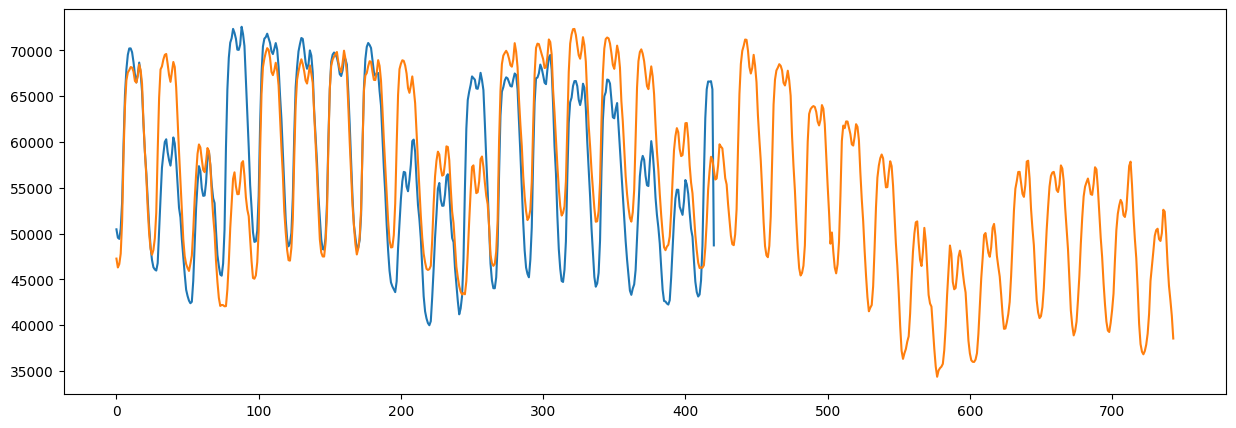

In [324]:
plt.figure(figsize=(15, 5))

series1 = df_hourly[(df_hourly.index.year == 2023) & (df_hourly.index.month == 12)]['gesamt']
series2 = df_hourly[(df_hourly.index.year == 2022) & (df_hourly.index.month == 12)]['gesamt']

len1 = len(series1)
len2 = len(series2)
max_len = np.max([len1, len2])

plt.plot(range(len1), series1)
plt.plot(range(len2), series2)
plt.show()